In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from netCDF4 import Dataset,date2num, num2date
import os
import netCDF4
import xarray as xr
import cartopy.crs as ccrs
import scipy

%matplotlib inline

In [2]:
from utils_local import plot_composites #local helperfunctions

In [3]:
HOME = "/scistor/ivm/the410"
os.chdir(f"{HOME}/CirculationTrends_Happe2025JCLi")

from GolfVijf.processing import load_and_subset_data, remove_spatmean_variability



In [4]:
os.chdir(HOME)

## Load and process Streamfunction data

In [5]:
var = "STREAM250" #"T2M" #"STREAM250"
longname =  "Streamfunction 250 hpa" #"Streamfunction 250 hpa" "2m surface temperature"
preprocessing = "seasonality_only" #"all", 'interannual_only', 'seasonality_only'"
unit = "m2/s" #"degrees C"

In [6]:
daJJA = load_and_subset_data(variable = var, months = [6,7,8], subdomain = 'midlat', ndays = 1)
daJJA.attrs["long_name"]= longname

In [7]:
midlatmean = daJJA.mean(['latitude','longitude']) #daily midlat mean
seas_midlatmean = midlatmean.groupby(midlatmean.time.dt.year).mean()#.to_pandas() #yearly midlat mean

Text(0.5, 1.0, 'Averages of Streamfunction 250 hpa over midlats NH')

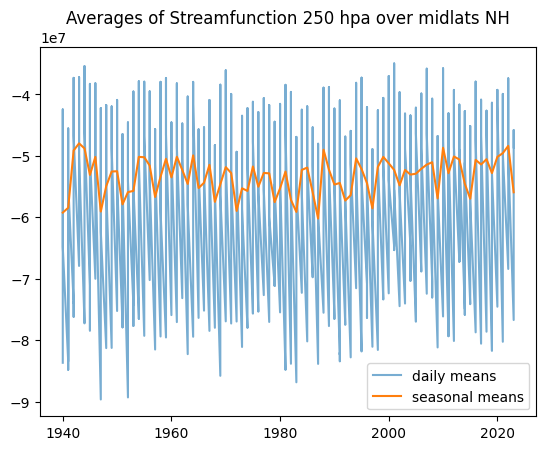

In [8]:
plt.plot(midlatmean.time.dt.year[:], midlatmean[:], label="daily means", alpha=0.6)
plt.plot(seas_midlatmean.year[:], seas_midlatmean[:], label="seasonal means")

plt.legend()
plt.title(f"Averages of {longname} over midlats NH")

In [9]:
daJJA_removed_seasonality = remove_spatmean_variability(daJJA, how=preprocessing)

/scistor/ivm/the410/test_tensorflow2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(
/scistor/ivm/the410/test_tensorflow2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:418: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  warnings.warn(


## Now load in ENSO data 

In [10]:
# different sst values\
enso = pd.read_csv(f"{HOME}/CirculationTrends_Happe2025JCLi/Data/enso_index_3monthly_3.4.csv", delimiter=';')

In [11]:
enso

,Year,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
0,1950,-1.5,-1.3,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8
1,1951,-0.8,-0.5,-0.2,0.2,0.4,0.6,0.7,0.9,1.0,1.2,1.0,0.8
2,1952,0.5,0.4,0.3,0.3,0.2,0.0,-0.1,0.0,0.2,0.1,0.0,0.1
3,1953,0.4,0.6,0.6,0.7,0.8,0.8,0.7,0.7,0.8,0.8,0.8,0.8
4,1954,0.8,0.5,0.0,-0.4,-0.5,-0.5,-0.6,-0.8,-0.9,-0.8,-0.7,-0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2019,0.7,0.7,0.7,0.7,0.5,0.5,0.3,0.1,0.2,0.3,0.5,0.5
70,2020,0.5,0.5,0.4,0.2,-0.1,-0.3,-0.4,-0.6,-0.9,-1.2,-1.3,-1.2
71,2021,-1.0,-0.9,-0.8,-0.7,-0.5,-0.4,-0.4,-0.5,-0.7,-0.8,-1.0,-1.0
72,2022,-1.0,-0.9,-1.0,-1.1,-1.0,-0.9,-0.8,-0.9,-1.0,-1.0,-0.9,-0.8


In [12]:
enso_months = "DJF" # 'DJF' "JJA"
enso_data = enso[enso_months].values #or any other month 

In [13]:
# The following two cells can be used to catagorize the data 

## transitional means from DJF in current year to DJF in following year, 
#with DJF of following year determining the enso state

# to save the indices of the days
enso_bins_indices = {"neutral": [],
             "La Nina persist": [], 
             "La Nina transitional": [], 
             "El Nino persist": [], 
             "El Nino transitional": []}


In [14]:
#For each day in the dataset, append to the enso_bin depending on the year value
data = daJJA_removed_seasonality.sel(time = daJJA_removed_seasonality.time.dt.year>=1950) #1950 onwards only
data = data.sel(time = data.time.dt.year<2023) #don't have this value yet...

#To split up the data in before and after 1979 
#data = data.sel(time = data.time.dt.year>=1979) 

#som_counts = np.zeros((k,np.unique(data.time.dt.year).shape[0]))
years = np.unique(data.time.dt.year)

for i in range(data.shape[0]): #iterate over the days 
    
    year = int(data.time.dt.year[i]) #int of year
    year_indice = np.where(years==year)[0] #get indice of corresponding year 
    
    #now add to enso_bin_array
    if enso_data[year_indice] > -0.5 and enso_data[year_indice] < 0.5:
        #"neutral year"
        enso_bins_indices["neutral"].append(i)
        
    elif enso_data[year_indice+1] < -0.5 and enso_data[year_indice] < -0.5:
        #"la nina persistent "
        enso_bins_indices["La Nina persist"].append(i)
        
    elif enso_data[year_indice+1] < -0.5 and enso_data[year_indice] >= -0.5:
        #"la nina transition "
        enso_bins_indices["La Nina transitional"].append(i)
        
    elif enso_data[year_indice+1] > 0.5 and enso_data[year_indice] > 0.5:
        #"el nino persistent "
        enso_bins_indices["El Nino persist"].append(i)
        
    elif enso_data[year_indice+1] > 0.5 and enso_data[year_indice] <= 0.5:
        #"el nino transition "
        enso_bins_indices["El Nino transitional"].append(i)        

# Create composites of NH var for each enso bin

In [15]:
# to get grid points anomalies 
grid_mean = np.nanmean(data, axis=0)
data_to_plot = data - grid_mean
data_to_plot.attrs["unit"] = unit

In [16]:
def plot_enso_state(enso_state, data_to_plot):
    enso_composite = np.nanmean(data_to_plot[enso_bins_indices[enso_state]], axis=0)
    n = len(enso_bins_indices[enso_state])
    plot_composites(enso_composite, data_to_plot.longitude, data_to_plot.latitude,
                title=f"preprocessing={preprocessing} {longname} composite of {enso_state} {enso_months} with n={n}", 
                    deseasonalized=True, unit=data_to_plot.attrs["unit"])

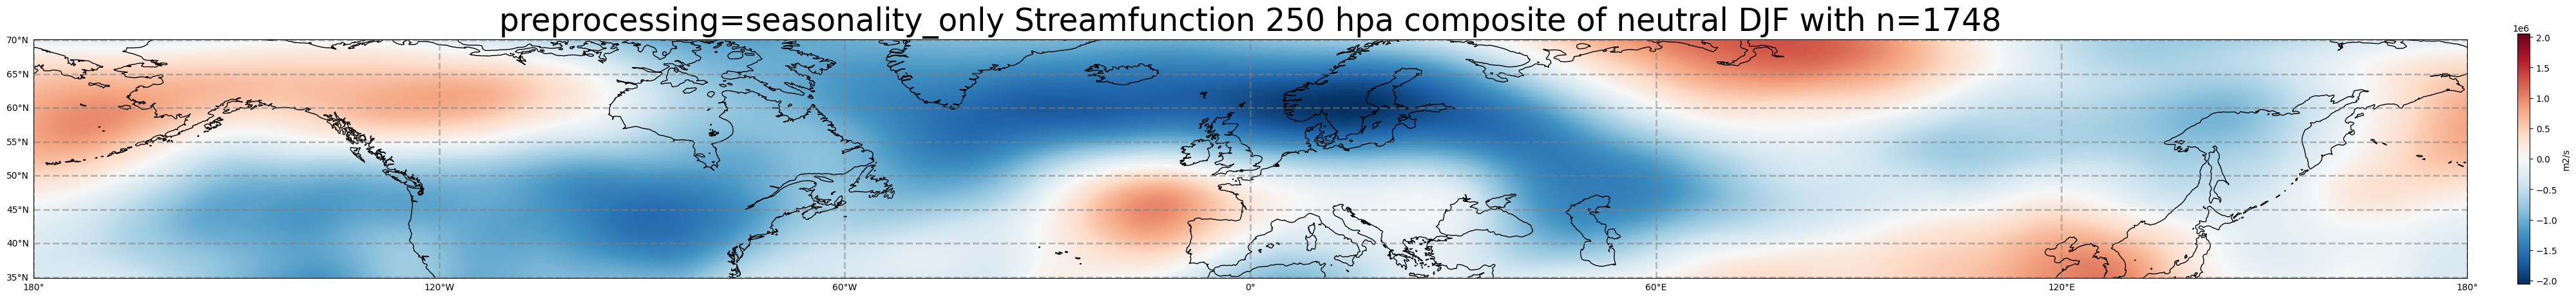

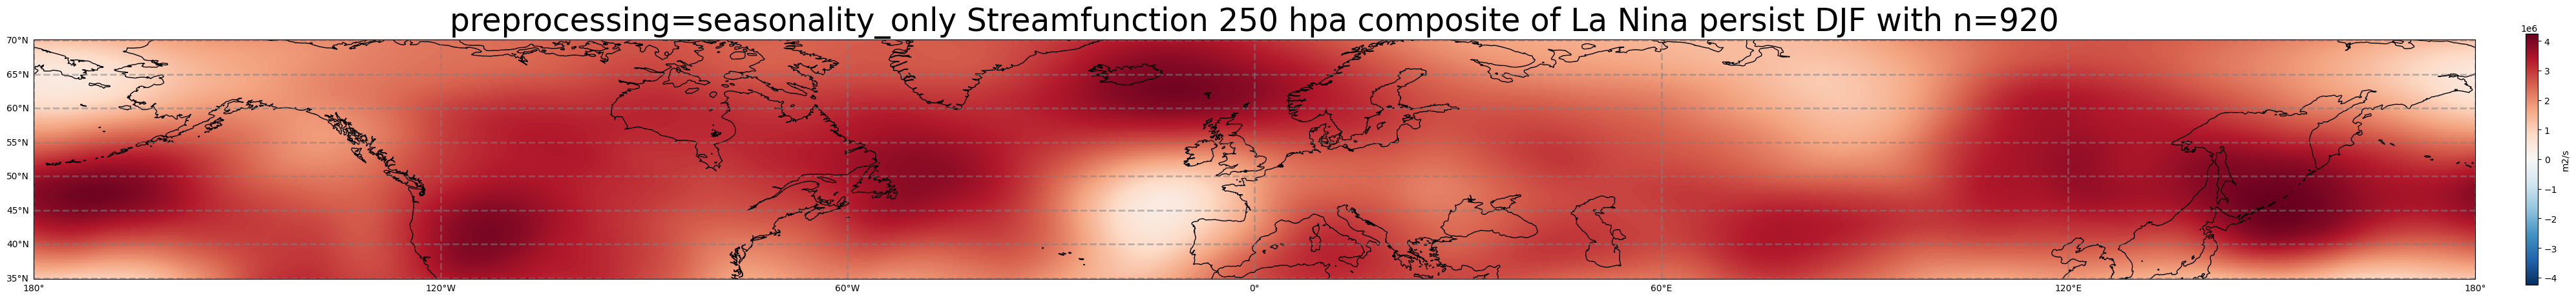

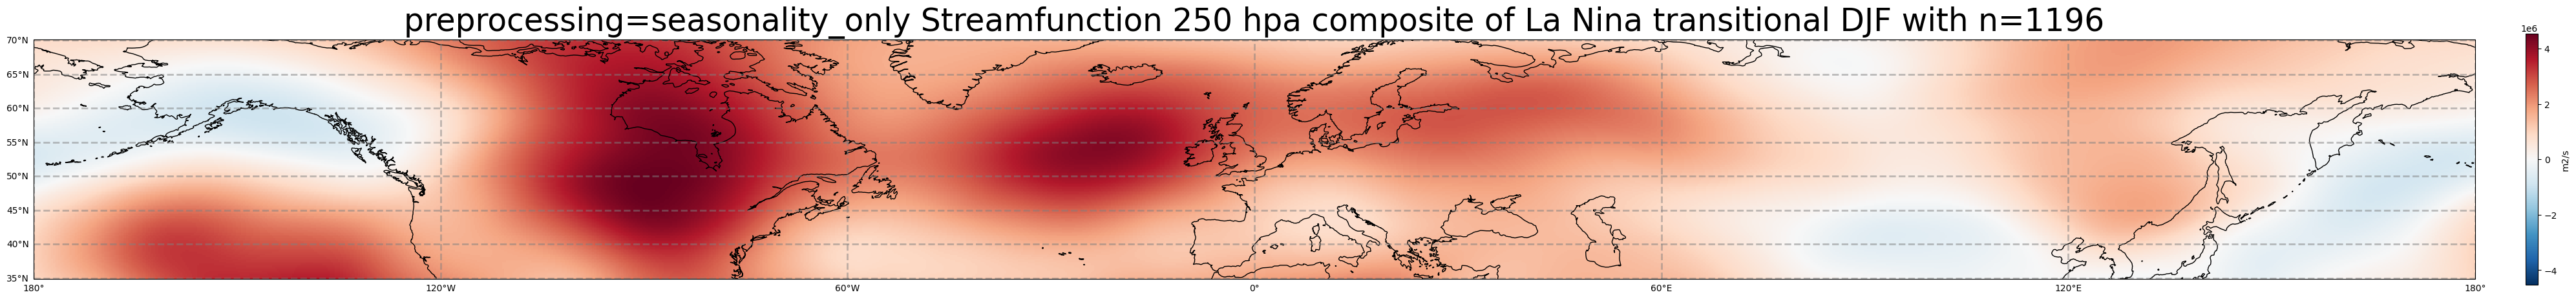

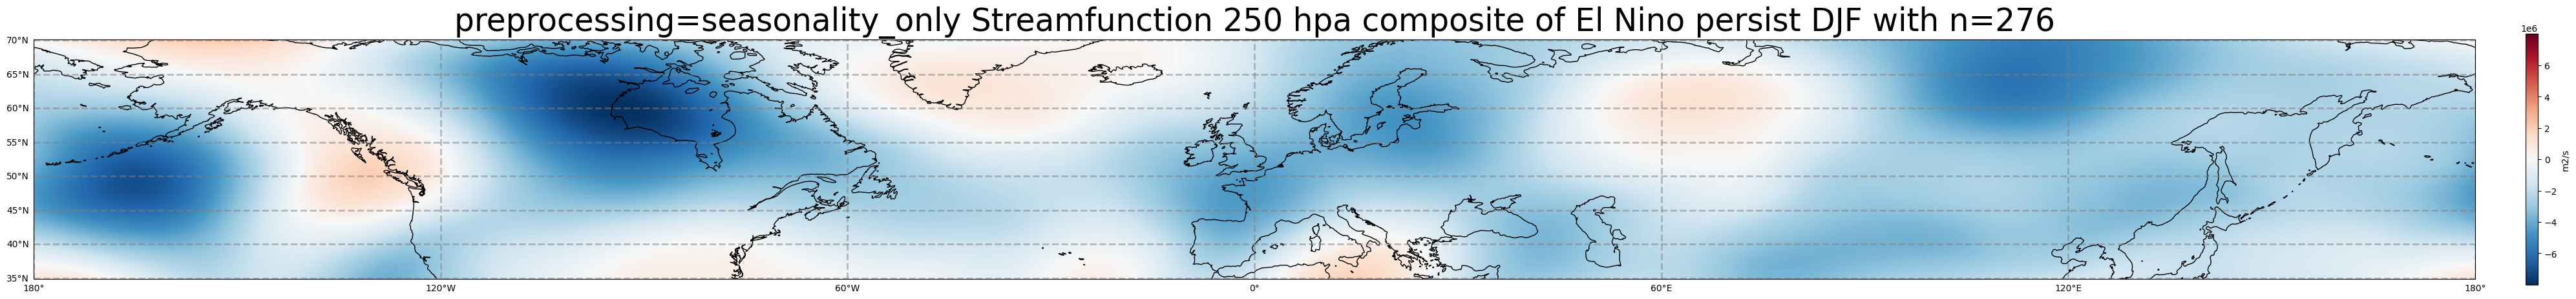

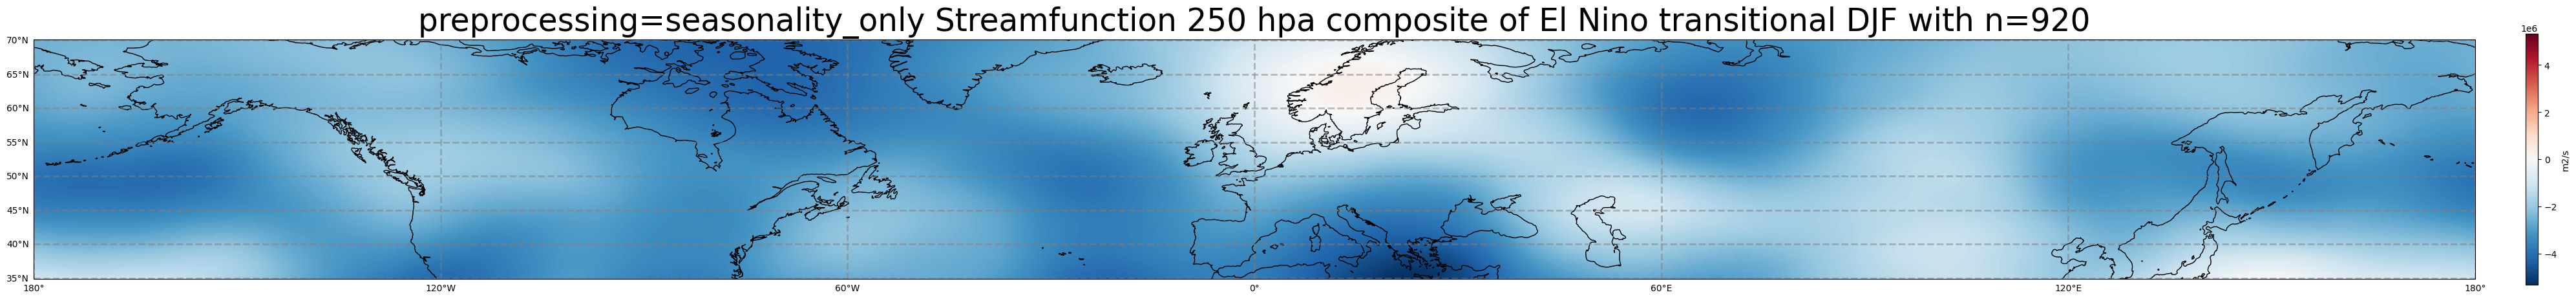

In [17]:
for enso_state in enso_bins_indices.keys():
    import warnings
    warnings.filterwarnings("ignore")
    plot_enso_state(enso_state, data_to_plot)